# Humor Detection

In [148]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import PunktSentenceTokenizer # unsupervised machine learning sentence tokenizer , can be trained, but we use the default
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Importing dataset
#dataset = pd.read_csv('files/train.csv', nrows=8000)
dataset = pd.read_csv('files/train.csv', nrows=1000)
print(dataset.shape)
print(dataset.head())


(1000, 6)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  offense_rating  
0          2.42                1.0             0.2  
1          2.50                1.0             1.1  
2          1.95                0.0             2.4  
3          2.11                1.0             0.0  
4          2.78                0.0             0.1  


## Exploratory Data Analysis

### Initial data selection

In [149]:

# selecting important columns only
# dropping 'offense_rating'
dataset = dataset[['id', 'text', 'is_humor', 'humor_rating', 'humor_controversy']]
print(dataset.shape)
print(dataset.head())

print("\n----- Describe ------")
print(dataset.describe())

(1000, 5)
   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   

   humor_rating  humor_controversy  
0          2.42                1.0  
1          2.50                1.0  
2          1.95                0.0  
3          2.11                1.0  
4          2.78                0.0  

----- Describe ------
                id     is_humor  humor_rating  humor_controversy
count  1000.000000  1000.000000    616.000000         616.000000
mean    500.500000     0.616000      2.263393           0.517857
std     288.819436     0.486601      0.571492           0.500087
min       1.000000     0.000000      0.100000           0.000000

In [44]:
# checks if there are null values

dataset.isnull().sum()

id                     0
text                   0
is_humor               0
humor_rating         384
humor_controversy    384
dtype: int64

This means we have to process these null values...

In [35]:
dataset[dataset['is_humor']==0].head()

,id,text,is_humor,humor_rating,humor_controversy
5,6,"'Trabajo,' the Spanish word for work, comes fr...",0,NaN,NaN
6,7,I enrolled on some skill training and extra cu...,0,NaN,NaN
8,9,Men who ejaculated 21 times or more a month ha...,0,NaN,NaN
9,10,I got REALLY angry today and it wasn't about n...,0,NaN,NaN
10,11,A dog in Mexico named Frida saved the lives of...,0,NaN,NaN


In [11]:
dataset[dataset['is_humor']==0].shape

(3068, 5)

As the number of null values is equal to the rows classifying the text as not humor, dropping these lines would drop rows with is_humor=0, and this would reflect in predicting is_humor.

### Data types

In [6]:
dataset.dtypes

id                     int64
text                  object
is_humor               int64
humor_rating         float64
humor_controversy    float64
dtype: object

And it's done! Now some graphics to analyse text statictics... (in progress)

### Text statistics analysis

#### No. of characters by each line

<AxesSubplot:>

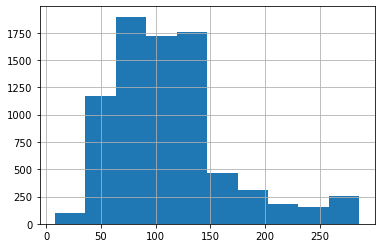

In [7]:
dataset['text'].str.len().hist()

This histogram shows that each line has, generally, between 40 to 150 characters.

#### No. of words by each line

<AxesSubplot:>

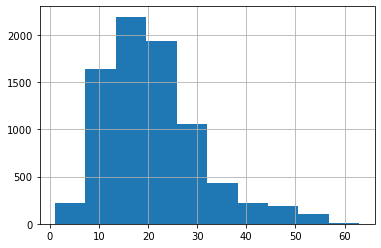

In [8]:
dataset['text'].str.split().\
    map(lambda x: len(x)).\
    hist()

For instance, this histogram shows that each line has, generally, between 10 and 30 words. 

#### Average word length

<AxesSubplot:>

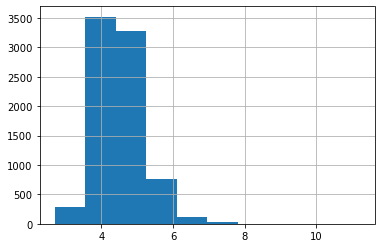

In [9]:
dataset['text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

This histogram shows that the average word length is mostly, between, 3 to 6 characters (with 4 and 5 being the most common length). So, this may show that the dataset has a high amount of stopwords and analyzing its amount and types can give a good insight about the data.

### Most common stopwords

<BarContainer object of 10 artists>

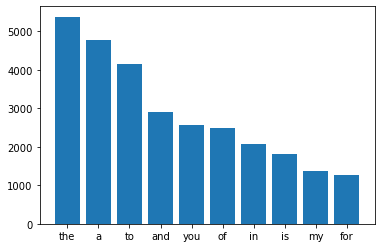

In [10]:
'''https://towardsdatascience.com/exploratory-data-analysis-for-natural-language-processing-ff0046ab3571'''

import matplotlib.pyplot as plt

corpus=[]
stop = set(stopwords.words('english'))
words = dataset['text'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

This plot shows that is important to remove stopwords, due to its frequency.

### Most common words (excluding stopwords)

After a initial analysis, we concluded that there were some common words with contractions. Therefore, we must first expand these contractions first and plot the common words after.

In [11]:
'''adapted from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/'''
from collections import Counter
import seaborn as sns

contractions_dict = {
     'I\'m': 'I am',
     'can\'t': 'can not',
     'We\'re': 'We are',
     'wasn\'t': 'was not',
     'you\'ve': 'you have',
     'What\'s': 'What is',
}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
    return contractions_re.sub(lambda match : contractions_dict[match.group(0)], text)

dataset['text'] = dataset['text'].apply(lambda x : expand_contractions(x))
print(dataset['text'].head(5))

words = dataset['text'].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]



0    TENNESSEE: We are the best state. Nobody even ...
1    A man inserted an advertisement in the classif...
2    How many men does it take to open a can of bee...
3    Told my mom I hit 1200 Twitter followers. She ...
4    Roses are dead. Love is fake. Weddings are bas...
Name: text, dtype: object


<AxesSubplot:>

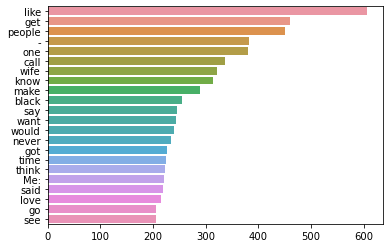

In [12]:
'''https://towardsdatascience.com/exploratory-data-analysis-for-natural-language-processing-ff0046ab3571'''

counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:100]:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

This plot means that 'me:', 'wife' and 'black', generally indicate that the sentence has humor. (temos que fazer matching disto com o is_humor)

### Humor rating distribution

<AxesSubplot:>

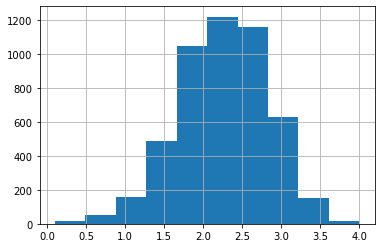

In [13]:
dataset['humor_rating'].hist()

## Data preprocessing

In [150]:


data_list =[]
#data_list2 =[]

raw_text =""
stop_words = tuple(set(stopwords.words("english")))

def lemmatization(token_sentence):
    res = []
    for word in token_sentence:
        lemmatizer.lemmatize(word)
        res.append(word)
    return res


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


# Simple test
def input_test(classifier):
    sample_text = input("Enter joke: ")
    sample_text = re.sub(r'[-.?!,:;()|0-9]', ' ', sample_text).lower().split()
    sample_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sample_text])
    aux_X = vectorizer.transform([sample_text]).toarray()
    
    #testing------------------------
    dfTesting = pd.DataFrame(aux_X.tolist())
    print(dfTesting)
    dfTesting["is_humor"] = float(input("Enter rating: "))
    dfTesting["controversial"] = int(input("Enter controversy: "))
    aux_X = dfTesting.to_numpy()
    np.nan_to_num(aux_X, copy=False)
    #testing------------------------
    

   # print(aux_X.shape)
    print(aux_X)

    if(classifier.predict(aux_X) == [1]):
        print("It's a joke! (+)")
    else:
        print("It's not a joke! (-)")

        
# range = dataset range
for i in range(0,dataset.shape[0]):
    
    humor_sentence = dataset['text'][i]

    #Tokenization by words or sentences
    humor_sentence = word_tokenize(humor_sentence)
    #remove stopwords and lemmatization with pos_tag
    humor_sentence = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence if word not in set(stopwords.words('english'))])  
      
    # remove alpha chars/not alphabetical caracters 
    #humor_sentence2 = re.sub(r'[-.?!,:;()|0-9]', ' ', dataset['text'][i])
   
    #humor_sentence2 = humor_sentence2.lower()
    #humor_sentence2 = word_tokenize(humor_sentence2)
    #humor_sentence2 = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_sentence2 if word not in set(stopwords.words('english'))])  
      
   #raw_text += aux_reader+ "\n"
   
    
    # aggregate all the rows of the dataset in one corpus ('data_list')
    data_list.append(humor_sentence)
    
    # how data_list2 is different from data_list?
    #data_list2.append(humor_sentence2)


#### creating a new dataset only with humor sentences (for humor_rating)

In [151]:
# creating a new dataset only with humor sentences (for humor_rating)
rating_dataset = dataset.copy(deep=True)

# dropping is_humor = 0 values
rating_dataset.dropna(inplace=True)
# resets the index
rating_dataset.reset_index(drop=True, inplace=True)
rating_dataset.isnull().sum()
print(rating_dataset.head(8))


   id                                               text  is_humor  \
0   1  TENNESSEE: We're the best state. Nobody even c...         1   
1   2  A man inserted an advertisement in the classif...         1   
2   3  How many men does it take to open a can of bee...         1   
3   4  Told my mom I hit 1200 Twitter followers. She ...         1   
4   5  Roses are dead. Love is fake. Weddings are bas...         1   
5   8  ME: I'm such an original. Truly one of a kind....         1   
6  12  What's the difference between a Mormon man and...         1   
7  13  Stop calling 9-1-1 because you've run out of t...         1   

   humor_rating  humor_controversy  
0          2.42                1.0  
1          2.50                1.0  
2          1.95                0.0  
3          2.11                1.0  
4          2.78                0.0  
5          1.79                1.0  
6          2.20                0.0  
7          1.50                1.0  


In [172]:
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
rating_dataset['ratingClass'] = pd.cut(rating_dataset['humor_rating'], bins).astype('category')
rating_dataset['ratingClass_code'] = rating_dataset['ratingClass'].cat.codes
rating_dataset

#pd.get_dummies(rating_dataset, columns=["ratingClass"]).head()

,id,text,is_humor,humor_rating,humor_controversy,ratingClass,ratingClass_code
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,"(2.0, 2.5]",4
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,"(2.0, 2.5]",4
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,"(1.5, 2.0]",3
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,"(2.0, 2.5]",4
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,"(2.5, 3.0]",5
...,...,...,...,...,...,...,...
611,991,Remember everyone who said “we’ll have to see ...,1,0.27,0.0,"(0.0, 0.5]",0
612,994,I finally got a snowblower and what a differen...,1,2.70,0.0,"(2.5, 3.0]",5
613,996,The guy who stole my diary just died. My thoug...,1,2.85,0.0,"(2.5, 3.0]",5
614,997,Two Irish men talking. - I saw my girlfriend g...,1,3.05,0.0,"(3.0, 3.5]",6


In [174]:
rating_dataset['ratingClass'].value_counts()

(2.0, 2.5]    200
(2.5, 3.0]    168
(1.5, 2.0]    146
(1.0, 1.5]     44
(3.0, 3.5]     38
(0.5, 1.0]     10
(3.5, 4.0]      6
(0.0, 0.5]      4
(4.5, 5.0]      0
(4.0, 4.5]      0
Name: ratingClass, dtype: int64

In [154]:
rating_data_list = []

for i in range(0,rating_dataset.shape[0]):
    humor_rating_sentence = rating_dataset['text'][i]
    #Tokenization by words or sentences
    humor_rating_sentence = word_tokenize(humor_rating_sentence)
    #remove stopwords and lemmatization with pos_tag
    humor_rating_sentence = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in humor_rating_sentence if word not in set(stopwords.words('english'))])  
    
    rating_data_list.append(humor_rating_sentence)

## Extract features from data

In [156]:

# Create bag-of-words model
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 8000)
vectorizer_rating_dataset = CountVectorizer(max_features = 8000)

# X, y are to classify is_humor
X = vectorizer.fit_transform(data_list).toarray() # no. of features per phrase (phrase=X[row])
y = dataset.iloc[:,2].values

# X, y are to classify humor_rating
X_2 = vectorizer_rating_dataset.fit_transform(rating_data_list).toarray()
y_2 = rating_dataset.iloc[:,6].values

print(vectorizer.get_feature_names())
print(X.shape, y.shape)



['000', '10', '100', '1000', '100ft', '106', '11th', '12', '1200', '13', '1313', '14', '14gm', '15', '150', '16', '17', '1759', '18', '1800', '1861', '1872', '19', '1930s', '1940', '1945', '1948', '1950s', '1964', '1984', '1995', '1998', '1st', '20', '200', '2000', '2001', '2003', '2013', '2014', '2017', '2018', '2019', '2020', '2052', '21', '2125', '22', '23', '24', '242', '25', '26', '28', '29', '30', '300k', '30pm', '31', '33', '35', '3629', '365', '37', '37th', '3d', '3rd', '40', '40th', '429', '43', '45', '48', '50', '500', '52', '57', '5sos', '60', '63', '666', '6x', '70', '72', '75', '80', '85', '90999', '911', '99', '999', 'aaaaafddasfrwe', 'abc', 'abdul', 'ability', 'able', 'aboard', 'about', 'abraham', 'abroad', 'absent', 'absolutely', 'absorption', 'abulia', 'abuse', 'abuzz', 'academy', 'accent', 'accept', 'acceptance', 'access', 'accessible', 'accident', 'accidentally', 'accord', 'account', 'accountable', 'accuse', 'accuses', 'achievement', 'ackles', 'acne', 'acquire', 'acr

In [157]:
print(vectorizer_2.get_feature_names())
print(X_2.shape, y_2.shape)

['000', '10', '100', '1000', '100ft', '106', '11th', '12', '1200', '13', '1313', '14', '14gm', '15', '150', '16', '17', '1759', '18', '1800', '1861', '1872', '19', '1930s', '1940', '1945', '1948', '1950s', '1964', '1984', '1995', '1998', '1st', '20', '200', '2000', '2001', '2003', '2013', '2014', '2017', '2018', '2019', '2020', '2052', '21', '2125', '22', '23', '24', '242', '25', '26', '28', '29', '30', '300k', '30pm', '31', '33', '35', '3629', '365', '37', '37th', '3d', '3rd', '40', '40th', '429', '43', '45', '48', '50', '500', '52', '57', '5sos', '60', '63', '666', '6x', '70', '72', '75', '80', '85', '90999', '911', '99', '999', 'aaaaafddasfrwe', 'abc', 'abdul', 'ability', 'able', 'aboard', 'about', 'abraham', 'abroad', 'absent', 'absolutely', 'absorption', 'abulia', 'abuse', 'abuzz', 'academy', 'accent', 'accept', 'acceptance', 'access', 'accessible', 'accident', 'accidentally', 'accord', 'account', 'accountable', 'accuse', 'accuses', 'achievement', 'ackles', 'acne', 'acquire', 'acr

#### Pandas DataFrame for humor and humor rating

In [70]:
# converting X (numpy array) to a pandas DataFrame
dataset_nlp_rating = pd.DataFrame(X_2.tolist(), columns=vectorizer_rating_dataset.get_feature_names())
print(dataset_nlp_rating)

     10  100  1000  100ft  106  12  1200  1313  14  15  ...  yo  yoda  you  \
0     0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
1     0    0     1      0    0   0     0     0   0   0  ...   0     0    1   
2     0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
3     0    0     0      0    0   0     1     0   0   0  ...   0     0    0   
4     0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
..   ..  ...   ...    ...  ...  ..   ...   ...  ..  ..  ...  ..   ...  ...   
611   0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
612   0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
613   0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
614   0    0     0      0    0   0     0     0   0   0  ...   0     0    0   
615   0    0     0      0    0   0     0     0   1   0  ...   0     0    0   

     young  your  zero  zombie  zombified  zone  ㅤㅤ  
0        

In [71]:

X_2 = dataset_nlp_rating.to_numpy()
print(X_2)
# missing values were replaced by NaN

# replace NaN with 0
np.nan_to_num(X_2, copy=False)
print(X_2)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
# converting X (numpy array) to a pandas DataFrame
dataset_nlp = pd.DataFrame(X.tolist(), columns=vectorizer.get_feature_names())
"""
# adding 'humor_rating' and 'humor_controversy' columns
dataset_nlp['humor_rating'] = dataset['humor_rating']
dataset_nlp['humor_controversy'] = dataset['humor_controversy']
print(dataset_nlp.head())

X = dataset_nlp.to_numpy()
print(X)
# missing values were replaced by NaN

# replace NaN with 0
np.nan_to_num(X, copy=False)
print(X)"""

"\n# adding 'humor_rating' and 'humor_controversy' columns\ndataset_nlp['humor_rating'] = dataset['humor_rating']\ndataset_nlp['humor_controversy'] = dataset['humor_controversy']\nprint(dataset_nlp.head())\n\nX = dataset_nlp.to_numpy()\nprint(X)\n# missing values were replaced by NaN\n\n# replace NaN with 0\nnp.nan_to_num(X, copy=False)\nprint(X)"

## Split dataset into training and test sets

In [158]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size = 0.20, random_state = 0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(800, 3973) (800,)
(200, 3973) (200,)
(492, 2615) (492,)
(124, 2615) (124,)


## Generate metrics

In [159]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred):
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # accuracy
    print('Accuracy: ', accuracy_score(y_test, y_pred))

    # precision
    print('Precision: ', precision_score(y_test, y_pred))

    # recall
    print('Recall: ', recall_score(y_test, y_pred))

    # f1
    print('F1: ', f1_score(y_test, y_pred))

In [185]:
def print_metrics_multiclass_target(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    # accuracy
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    # precision
    print('Precision: ', precision_score(y_test, y_pred, average='micro'))
    # recall
    print('Recall: ', recall_score(y_test, y_pred, average='micro'))
    # f1
    print('F1: ', f1_score(y_test, y_pred, average='micro'))

## Text Classification

In [186]:

# Fit Naive Bayes to the training set

from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)
#is_humor
# Predict test set results
y_pred = classifier.predict(X_test)
print_metrics(y_test, y_pred)

#humor rating
classifier2 = GaussianNB()
classifier2.fit(X2_train, y2_train)

# Predict test set results
y2_pred = classifier2.predict(X2_test)

print_metrics_multiclass_target(y2_test, y2_pred)

[[58 22]
 [40 80]]
Accuracy:  0.69
Precision:  0.7843137254901961
Recall:  0.6666666666666666
F1:  0.7207207207207207
[[ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  0  3  6  2  0  0]
 [ 0  1  0 10  7 10  0  0]
 [ 0  0  0 19  9 14  1  0]
 [ 0  0  0  8  9  5  0  0]
 [ 0  0  1  2  5  7  0  0]
 [ 0  0  0  0  1  1  0  0]]
Accuracy:  0.1935483870967742
Precision:  0.1935483870967742
Recall:  0.1935483870967742
F1:  0.1935483870967742


In [77]:
input_test(classifier)





Enter joke: Roses are dead. Love is fake. Weddings are basically funerals with cake.
   0     1     2     3     4     5     6     7     8     9     ...  7990  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   

   7991  7992  7993  7994  7995  7996  7997  7998  7999  
0     0     0     0     0     0     0     0     0     0  

[1 rows x 8000 columns]
Enter rating: 0.9
Enter controversy: 0
[[0.  0.  0.  ... 0.  0.9 0. ]]
It's a joke! (+)


In [187]:
# SVM

from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = SVC()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 26  54]
 [  3 117]]
Accuracy:  0.715
Precision:  0.6842105263157895
Recall:  0.975
F1:  0.8041237113402062
[[ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  1  0  0]
 [ 0  0  0  0 11  0  0  0]
 [ 0  0  0  0 19  9  0  0]
 [ 0  0  0  0 29 14  0  0]
 [ 0  0  0  0 15  7  0  0]
 [ 0  0  0  0 11  4  0  0]
 [ 0  0  0  0  2  0  0  0]]
Accuracy:  0.2903225806451613
Precision:  0.2903225806451613
Recall:  0.2903225806451613
F1:  0.2903225806451613


In [38]:
input_test(classifier)

Enter joke: What word in English language is always spelled incorrectly? Answer : Incorrectly
Enter rating: 0.4
Enter controversy: 0
(1, 3975)
[[0.  0.  0.  ... 0.  0.4 0. ]]
It's not a joke! (-)


In [188]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = LogisticRegression()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 42  38]
 [ 12 108]]
Accuracy:  0.75
Precision:  0.7397260273972602
Recall:  0.9
F1:  0.8120300751879699
[[ 0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  1  2  6  2  0  0]
 [ 0  0  0  6 11 11  0  0]
 [ 0  0  0  8 19 16  0  0]
 [ 0  0  0  6 10  6  0  0]
 [ 0  0  0  2  6  7  0  0]
 [ 0  0  0  0  1  1  0  0]]
Accuracy:  0.25806451612903225
Precision:  0.25806451612903225
Recall:  0.25806451612903225
F1:  0.25806451612903225


In [93]:
#input_test(classifier)

In [189]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = MLPClassifier()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 46  34]
 [ 18 102]]
Accuracy:  0.74
Precision:  0.75
Recall:  0.85
F1:  0.7968749999999999
[[ 0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  0  1  8  2  0  0]
 [ 0  0  0  8 11  8  1  0]
 [ 0  0  0 11 15 17  0  0]
 [ 0  0  0  4 12  6  0  0]
 [ 0  0  0  3  6  6  0  0]
 [ 0  0  0  0  1  1  0  0]]
Accuracy:  0.23387096774193547
Precision:  0.23387096774193547
Recall:  0.23387096774193547
F1:  0.23387096774193547


In [101]:
#input_test(classifier)

In [191]:
from sklearn.neural_network import BernoulliRBM
lassifier = BernoulliRBM()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = BernoulliRBM()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 47  33]
 [ 19 101]]
Accuracy:  0.74
Precision:  0.753731343283582
Recall:  0.8416666666666667
F1:  0.7952755905511811


AttributeError: 'BernoulliRBM' object has no attribute 'predict'

In [103]:
#input_test(classifier)

In [192]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = KNeighborsClassifier()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[78  2]
 [92 28]]
Accuracy:  0.53
Precision:  0.9333333333333333
Recall:  0.23333333333333334
F1:  0.37333333333333335
[[ 0  0  0  0  0  1  0  0]
 [ 0  1  0  0  0  1  0  0]
 [ 0  0  5  1  3  2  0  0]
 [ 0  2  6  8  9  3  0  0]
 [ 2  2 10 10 14  5  0  0]
 [ 1  0  6  6  9  0  0  0]
 [ 0  0  5  4  5  1  0  0]
 [ 0  0  1  1  0  0  0  0]]
Accuracy:  0.22580645161290322
Precision:  0.22580645161290322
Recall:  0.22580645161290322
F1:  0.22580645161290322


In [193]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print_metrics(y_test, y_pred)

#humor rating
classifier2 = MultinomialNB()
classifier2.fit(X2_train, y2_train)
y2_pred = classifier2.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 54  26]
 [  8 112]]
Accuracy:  0.83
Precision:  0.8115942028985508
Recall:  0.9333333333333333
F1:  0.8682170542635659
[[ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  0  1  9  1  0  0]
 [ 0  0  0  6 14  8  0  0]
 [ 0  0  0 10 15 18  0  0]
 [ 0  0  0  6  9  6  1  0]
 [ 0  0  0  2  6  7  0  0]
 [ 0  0  0  0  1  1  0  0]]
Accuracy:  0.21774193548387097
Precision:  0.21774193548387097
Recall:  0.21774193548387097
F1:  0.21774193548387097


In [194]:
classifiers = [ ("cfl1",LogisticRegression()),("cfl2",SVC()),("cfl3",GaussianNB()),("cfl4",MultinomialNB()),("cfl5",MLPClassifier())]

from sklearn.ensemble import VotingClassifier

v_c = VotingClassifier(estimators= classifiers, voting="hard",n_jobs = -1)
v_c = v_c.fit(X_train,y_train)
y_pred = v_c.predict(X_test)
print_metrics(y_test, y_pred)

[[ 43  37]
 [  7 113]]
Accuracy:  0.78
Precision:  0.7533333333333333
Recall:  0.9416666666666667
F1:  0.837037037037037


In [196]:
classifiers = [ ("cfl1",LogisticRegression()),("cfl2",SVC()),("cfl3",GaussianNB()),("cfl4",MultinomialNB()),("cfl5",MLPClassifier())]

from sklearn.ensemble import VotingClassifier

v_c = VotingClassifier(estimators= classifiers, voting="hard",n_jobs = -1)
v_c = v_c.fit(X2_train,y2_train)
y2_pred = v_c.predict(X2_test)
print_metrics_multiclass_target(y2_test, y2_pred)

[[ 0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  1  0  0]
 [ 0  0  0  1  9  1  0  0]
 [ 0  0  0  7 14  7  0  0]
 [ 0  0  0 10 19 14  0  0]
 [ 0  0  0  5 12  5  0  0]
 [ 0  0  0  2  7  6  0  0]
 [ 0  0  0  0  1  1  0  0]]
Accuracy:  0.25
Precision:  0.25
Recall:  0.25
F1:  0.25
